# HOPE Pilot v2 - Scalable Dataset Training

This notebook trains the **HOPE Pilot model (200M parameters)** with **flexible dataset sizes**.

**New in v2:**
- 📊 **Dataset size presets**: Debug, Quick, Standard, Chinchilla-Optimal, Large
- 🧠 **Smart memory management**: Auto RAM vs memory-mapped files
- 📈 **Scaling guidance**: Shows trade-offs for each preset
- 💾 **Efficient loading**: Handles datasets from 1M to 50B+ tokens

**Dataset Presets:**
- **Debug** (1M tokens): ~1 min download - Test pipeline
- **Quick** (50M tokens): ~10 min download - Quick experiments  
- **Standard** (500M tokens): ~2 hours download - Decent results
- **Chinchilla** (3.1B tokens): ~1 day download - Optimal for 155M model
- **Large** (10B tokens): ~3 days download - High quality
- **Custom**: Specify your own token count

## 1. Setup and Installation

In [1]:
# Install dependencies
!pip install -q torch numpy einops tqdm sentencepiece omegaconf matplotlib datasets huggingface-hub langdetect ipywidgets zstandard psutil

In [2]:
# Detect environment: Google Colab vs Local
import os
import glob

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("="*80)
print(f"ENVIRONMENT: {'Google Colab' if IN_COLAB else 'Local'}")
print("="*80)

# Setup directories based on environment
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    DRIVE_ROOT = '/content/drive/MyDrive/hope_pilot_v2'
    CHECKPOINT_DIR = f'{DRIVE_ROOT}/checkpoints'
    DATA_DIR = f'{DRIVE_ROOT}/data'
    TOKENIZER_DIR = f'{DRIVE_ROOT}/tokenizer'
    
    print("✓ Google Drive mounted successfully!")
else:
    import pathlib
    notebook_dir = pathlib.Path.cwd()
    
    DRIVE_ROOT = notebook_dir / 'hope_pilot_v2_data'
    CHECKPOINT_DIR = str(DRIVE_ROOT / 'checkpoints')
    DATA_DIR = str(DRIVE_ROOT / 'data')
    TOKENIZER_DIR = str(DRIVE_ROOT / 'tokenizer')
    
    print(f"✓ Running locally in: {notebook_dir}")

# Create directories
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

print(f"📁 Directories:")
print(f"  Checkpoints: {CHECKPOINT_DIR}")
print(f"  Data: {DATA_DIR}")
print(f"  Tokenizer: {TOKENIZER_DIR}")
print("="*80)

ENVIRONMENT: Local
✓ Running locally in: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning
📁 Directories:
  Checkpoints: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/checkpoints
  Data: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/data
  Tokenizer: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/tokenizer


## 2. Imports and Device Configuration

Load all required libraries and detect available compute device (CUDA, MPS, or CPU).

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import time
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Dict, List, Optional
import json
from collections import Counter
import glob
import multiprocessing
import psutil

# FIX for "Broken pipe" error on macOS
if __name__ != '__main__':
    try:
        multiprocessing.set_start_method('fork', force=True)
    except RuntimeError:
        pass

# Fix fsspec zstd compression support for SlimPajama dataset
import fsspec.utils
try:
    import zstandard
    if 'zst' not in fsspec.utils.compressions:
        fsspec.utils.compressions['zst'] = 'zstd'
        fsspec.utils.compressions['zstd'] = 'zstd'
except ImportError:
    pass

# Check for GPU availability (CUDA, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_name = torch.cuda.get_device_name(0)
    device_type = "CUDA GPU"
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    device_name = "Apple Silicon GPU"
    device_type = "MPS (Metal Performance Shaders)"
    total_memory = None
else:
    device = torch.device('cpu')
    device_name = "CPU"
    device_type = "CPU"
    total_memory = None

print(f"Using device: {device} ({device_type})")
if device.type == 'cuda':
    print(f"GPU: {device_name}")
    print(f"GPU Memory: {total_memory:.2f} GB")
elif device.type == 'mps':
    print(f"GPU: {device_name}")
    mem = psutil.virtual_memory()
    print(f"Unified Memory: {mem.total / 1e9:.1f} GB total")

Using device: mps (MPS (Metal Performance Shaders))
GPU: Apple Silicon GPU
Unified Memory: 34.4 GB total


## 3. Dataset Size Configuration

Choose your dataset size based on your goals and resources.

## 4. Training Configuration

Configure training steps and model parameters.

In [4]:
# GPU Memory Tracking Utilities
def print_gpu_memory(stage_name: str = ""):
    """Print current GPU memory usage (CUDA has full tracking, MPS has limited)"""
    if torch.cuda.is_available() and device.type == 'cuda':
        allocated = torch.cuda.memory_allocated() / (1024**3)  # GB
        reserved = torch.cuda.memory_reserved() / (1024**3)    # GB
        total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        free = total - reserved
        
        print(f"\n{'='*80}")
        print(f"GPU MEMORY: {stage_name}")
        print(f"{'='*80}")
        print(f"📊 Allocated (actual usage):  {allocated:6.2f} GB / {total:.2f} GB ({allocated/total*100:5.1f}%)")
        print(f"📦 Reserved (by PyTorch):     {reserved:6.2f} GB / {total:.2f} GB ({reserved/total*100:5.1f}%)")
        print(f"💚 Free (available):          {free:6.2f} GB / {total:.2f} GB ({free/total*100:5.1f}%)")
        print(f"{'='*80}\n")
        
        return {
            'allocated_gb': allocated,
            'reserved_gb': reserved,
            'free_gb': free,
            'total_gb': total
        }
    elif device.type == 'mps':
        print(f"\n{'='*80}")
        print(f"GPU MEMORY: {stage_name}")
        print(f"{'='*80}")
        
        # Try PyTorch 2.0+ MPS memory APIs (limited but better than nothing)
        if hasattr(torch.mps, 'current_allocated_memory'):
            allocated = torch.mps.current_allocated_memory() / (1024**3)
            print(f"🍎 MPS Allocated: {allocated:.2f} GB")
            
            if hasattr(torch.mps, 'driver_allocated_memory'):
                driver = torch.mps.driver_allocated_memory() / (1024**3)
                print(f"🔧 Metal Driver:  {driver:.2f} GB")
        else:
            print(f"🍎 MPS - Direct memory tracking not available (requires PyTorch 2.0+)")
        
        # Show system memory as proxy (unified memory architecture)
        try:
            mem = psutil.virtual_memory()
            print(f"💾 Unified Memory: {mem.used / (1024**3):.2f} GB / {mem.total / (1024**3):.2f} GB")
            print(f"📊 Available: {mem.available / (1024**3):.2f} GB ({100 - mem.percent:.1f}%)")
        except ImportError:
            pass
        
        print(f"💡 For detailed GPU tracking: pip install asitop && sudo asitop")
        print(f"{'='*80}\n")
        return None
    else:
        print(f"\n⚠️  No GPU available for {stage_name}")
        return None

# Clear any cached memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

print("✓ Memory tracking utilities loaded")

✓ Memory tracking utilities loaded


In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# DATASET SIZE PRESET SELECTION
# ═══════════════════════════════════════════════════════════════════════════════

DATA_PRESET = "chinchilla"  # Options: "debug", "quick", "standard", "chinchilla", "large", "custom"

# Preset configurations
DATA_PRESETS = {
    "debug": {
        "target_tokens": 1_000_000,  # 1M tokens
        "doc_multiplier": 0.1,
        "download_time_min": 1,
        "disk_space_gb": 0.01,
        "description": "Tiny dataset for testing pipeline",
        "quality": "⭐ (Poor - just for testing)",
        "use_case": "Debug code, test setup"
    },
    "quick": {
        "target_tokens": 50_000_000,  # 50M tokens
        "doc_multiplier": 5,
        "download_time_min": 10,
        "disk_space_gb": 0.5,
        "description": "Small dataset for quick experiments",
        "quality": "⭐⭐ (Basic)",
        "use_case": "Quick experiments, prototyping"
    },
    "standard": {
        "target_tokens": 500_000_000,  # 500M tokens
        "doc_multiplier": 50,
        "download_time_min": 120,
        "disk_space_gb": 5,
        "description": "Medium dataset for decent results",
        "quality": "⭐⭐⭐ (Good)",
        "use_case": "Research, decent training runs"
    },
    "chinchilla": {
        "target_tokens": 3_100_000_000,  # 3.1B tokens (20x 155M params)
        "doc_multiplier": 310,
        "download_time_min": 1440,  # ~1 day
        "disk_space_gb": 25,
        "description": "Chinchilla-optimal for 155M params (20 tokens/param)",
        "quality": "⭐⭐⭐⭐ (Excellent)",
        "use_case": "Optimal training, paper-quality results"
    },
    "large": {
        "target_tokens": 10_000_000_000,  # 10B tokens
        "doc_multiplier": 1000,
        "download_time_min": 4320,  # ~3 days
        "disk_space_gb": 80,
        "description": "Large dataset for high quality",
        "quality": "⭐⭐⭐⭐⭐ (Exceptional)",
        "use_case": "Production-quality, state-of-art"
    },
    "custom": {
        "target_tokens": 1_000_000_000,  # 1B tokens (modify this!)
        "doc_multiplier": 100,
        "download_time_min": None,
        "disk_space_gb": None,
        "description": "Custom size - edit target_tokens above",
        "quality": "Custom",
        "use_case": "Your specific needs"
    }
}

data_config = DATA_PRESETS[DATA_PRESET]

print("═" * 80)
print(f"DATASET PRESET: {DATA_PRESET.upper()}")
print("═" * 80)
print(f"📊 {data_config['description']}")
print(f"🎯 Target tokens: {data_config['target_tokens']:,} ({data_config['target_tokens']/1e9:.2f}B)")
print(f"📈 Quality: {data_config['quality']}")
print(f"💡 Use case: {data_config['use_case']}")
if data_config['download_time_min']:
    hours = data_config['download_time_min'] / 60
    if hours < 1:
        print(f"⏱️  Download time: ~{data_config['download_time_min']} minutes")
    elif hours < 24:
        print(f"⏱️  Download time: ~{hours:.1f} hours")
    else:
        print(f"⏱️  Download time: ~{hours/24:.1f} days")
if data_config['disk_space_gb']:
    print(f"💾 Disk space: ~{data_config['disk_space_gb']:.1f} GB")

# Calculate optimal training steps for this dataset
model_params = 155_000_000  # Your model size
optimal_steps_chinchilla = data_config['target_tokens'] // 512  # Assuming seq_len=512
print(f"\n📐 Model size: {model_params:,} parameters ({model_params/1e6:.0f}M)")
print(f"🎯 Chinchilla ratio: {data_config['target_tokens']/model_params:.1f} tokens/param")
if data_config['target_tokens'] < model_params * 20:
    print(f"   ⚠️  Below optimal (20 tokens/param) - may underfit")
elif data_config['target_tokens'] > model_params * 100:
    print(f"   ℹ️  Above optimal - diminishing returns after {model_params*20:,} tokens")
else:
    print(f"   ✅ Good range for this model size")

print(f"\n💡 To change preset, edit DATA_PRESET above")
print(f"   Options: 'debug', 'quick', 'standard', 'chinchilla', 'large', 'custom'")
print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
DATASET PRESET: CHINCHILLA
════════════════════════════════════════════════════════════════════════════════
📊 Chinchilla-optimal for 155M params (20 tokens/param)
🎯 Target tokens: 3,100,000,000 (3.10B)
📈 Quality: ⭐⭐⭐⭐ (Excellent)
💡 Use case: Optimal training, paper-quality results
⏱️  Download time: ~1.0 days
💾 Disk space: ~25.0 GB

📐 Model size: 155,000,000 parameters (155M)
🎯 Chinchilla ratio: 20.0 tokens/param
   ✅ Good range for this model size

💡 To change preset, edit DATA_PRESET above
   Options: 'debug', 'quick', 'standard', 'chinchilla', 'large', 'custom'
════════════════════════════════════════════════════════════════════════════════


## 5. Model Configuration

Configure the HOPE Pilot model architecture (155M parameters).

In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 MASTER CONFIGURATION - CHANGE SETTINGS HERE!
# ═══════════════════════════════════════════════════════════════════════════════
# This is the ONLY place you need to edit to change training parameters.
# All other cells will automatically use these values.

# TRAINING CONFIGURATION (Optimized for 32GB Mac with MPS)
BATCH_SIZE = 2              # Reduced for Option 2 memory requirements
SEQ_LEN = 2048              # Context window length (2048 = matches official spec)
TOTAL_STEPS = 740001        # Adjusted to maintain same total tokens (2 * 2048 * 740,001 = 3.03B)
SAVE_INTERVAL = 1000        # Save checkpoint every N steps

# LEARNING RATES (Official spec from GitHub repo)
TITAN_LR = 6.0e-4           # TITAN level learning rate
CMS_LR = 3.0e-4             # CMS levels learning rate

# CALCULATED VALUES (Don't change these - auto-calculated)
TOKENS_PER_STEP = BATCH_SIZE * SEQ_LEN
TOTAL_TOKENS = TOTAL_STEPS * TOKENS_PER_STEP
TOTAL_TOKENS_B = TOTAL_TOKENS / 1e9

print("═" * 80)
print("🎯 TRAINING CONFIGURATION")
print("═" * 80)
print(f"Batch Size:      {BATCH_SIZE}")
print(f"Sequence Length: {SEQ_LEN:,}")
print(f"Total Steps:     {TOTAL_STEPS:,}")
print(f"")
print(f"Tokens/Step:     {TOKENS_PER_STEP:,}")
print(f"Total Tokens:    {TOTAL_TOKENS:,} ({TOTAL_TOKENS_B:.2f}B)")
print(f"")
print(f"Learning Rates:")
print(f"  TITAN: {TITAN_LR}")
print(f"  CMS:   {CMS_LR}")
print("═" * 80)
print()
print("💡 To change settings, edit the values at the top of this cell!")
print("   All other cells will automatically use these values.")
print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
🎯 TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════════════════════
Batch Size:      2
Sequence Length: 2,048
Total Steps:     740,001

Tokens/Step:     4,096
Total Tokens:    3,031,044,096 (3.03B)

Learning Rates:
  TITAN: 0.0006
  CMS:   0.0003
════════════════════════════════════════════════════════════════════════════════

💡 To change settings, edit the values at the top of this cell!
   All other cells will automatically use these values.
════════════════════════════════════════════════════════════════════════════════


In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# PILOT MODEL CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

@dataclass
class PilotConfig:
    """HOPE Pilot model configuration (155M parameters)"""
    
    # Architecture
    vocab_size: int = 32000          # SentencePiece vocab size
    dim: int = 512                   # Model dimension
    num_layers: int = 12             # Number of transformer layers
    heads: int = 8                   # Number of attention heads
    seq_len: int = SEQ_LEN               # From master config above
    
    # Training
    batch_size: int = BATCH_SIZE         # From master config above
    total_steps: int = TOTAL_STEPS       # From master config above
    save_interval: int = SAVE_INTERVAL   # From master config above
    
    # Learning rates
    titan_lr: float = TITAN_LR           # From master config above
    cms_lr: float = CMS_LR               # From master config above
    
    # Nested learning parameters
    teach_scale: float = 0.10        # Teaching signal scale
    teach_clip: float = 5.0          # Gradient clipping for teach signals
    surprise_threshold: float = 0.02 # Threshold for surprise-based learning
    self_mod_lr: float = 0.001       # Self-modulation learning rate
    
    # Multi-timescale update periods
    titan_period: int = 8            # TITAN updates every 8 steps
    cms_fast_period: int = 1         # Fast CMS updates every step
    cms_mid_period: int = 4          # Mid CMS updates every 4 steps
    cms_slow_period: int = 32        # Slow CMS updates every 32 steps
    cms_ultra_period: int = 128      # Ultra-slow CMS updates every 128 steps
    
    # Teaching signal schedule
    teach_warmup_steps: int = 2000
    teach_decay_start: int = 120000
    teach_decay_duration: int = 20000
    
    # Mixed precision (automatic based on device)
    use_amp: bool = device.type in ['cuda', 'mps']
    dtype: str = 'bf16' if device.type == 'cuda' else 'fp32'

# Create config instance
config = PilotConfig()

# Print model summary
print("═" * 80)
print("PILOT MODEL CONFIGURATION")
print("═" * 80)
print(f"\n📐 Architecture:")
print(f"  • Vocabulary size: {config.vocab_size:,}")
print(f"  • Model dimension: {config.dim}")
print(f"  • Transformer layers: {config.num_layers}")
print(f"  • Attention heads: {config.heads}")
print(f"  • Sequence length: {config.seq_len}")

# Calculate parameter count
params_per_layer = (
    4 * config.dim * config.dim +  # Attention QKV + output projection
    3 * config.dim +               # LayerNorm parameters
    8 * config.dim * config.dim +  # FFN (4x expansion)
    2 * config.dim                 # FFN LayerNorm
)
embedding_params = config.vocab_size * config.dim
total_params = embedding_params + (params_per_layer * config.num_layers)
print(f"  • Total parameters: ~{total_params/1e6:.1f}M")

print(f"\n🎯 Training:")
print(f"  • Batch size: {config.batch_size} (optimized for memory bandwidth)")
print(f"  • Total steps: {config.total_steps:,}")
print(f"  • Tokens per step: {config.batch_size * config.seq_len:,}")
print(f"  • Total tokens seen: {config.total_steps * config.batch_size * config.seq_len:,} ({config.total_steps * config.batch_size * config.seq_len / 1e9:.2f}B)")
print(f"  • Checkpoint interval: {config.save_interval:,} steps")

print(f"\n🔄 Multi-timescale Learning:")
print(f"  • TITAN period: {config.titan_period} steps (slow, global patterns)")
print(f"  • CMS Fast: {config.cms_fast_period} steps (immediate feedback)")
print(f"  • CMS Mid: {config.cms_mid_period} steps (short-term patterns)")
print(f"  • CMS Slow: {config.cms_slow_period} steps (medium-term patterns)")
print(f"  • CMS Ultra: {config.cms_ultra_period} steps (long-term patterns)")

print(f"\n⚡ Mixed Precision:")
if config.use_amp:
    print(f"  • Enabled: {config.dtype} (automatic mixed precision)")
    if device.type == 'cuda':
        print(f"  • GPU: CUDA with bfloat16")
    else:
        print(f"  • GPU: MPS with automatic AMP")
else:
    print(f"  • Disabled (CPU mode)")

print(f"\n💾 Dataset vs Model:")
tokens_seen = config.total_steps * config.batch_size * config.seq_len
print(f"  • Dataset size: {data_config['target_tokens']:,} tokens")
print(f"  • Tokens in training: {tokens_seen:,} tokens")
print(f"  • Dataset coverage: {tokens_seen / data_config['target_tokens']:.2f}x")
if tokens_seen < data_config['target_tokens']:
    print(f"    ℹ️  Will see {tokens_seen / data_config['target_tokens'] * 100:.1f}% of dataset (< 1 epoch)")
elif tokens_seen > data_config['target_tokens'] * 3:
    print(f"    ⚠️  Will see dataset {tokens_seen / data_config['target_tokens']:.1f}x (may overfit)")
else:
    print(f"    ✅ Good coverage ({tokens_seen / data_config['target_tokens']:.1f}x passes)")

print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
PILOT MODEL CONFIGURATION
════════════════════════════════════════════════════════════════════════════════

📐 Architecture:
  • Vocabulary size: 32,000
  • Model dimension: 512
  • Transformer layers: 12
  • Attention heads: 8
  • Sequence length: 2048
  • Total parameters: ~54.2M

🎯 Training:
  • Batch size: 2 (optimized for memory bandwidth)
  • Total steps: 740,001
  • Tokens per step: 4,096
  • Total tokens seen: 3,031,044,096 (3.03B)
  • Checkpoint interval: 1,000 steps

🔄 Multi-timescale Learning:
  • TITAN period: 8 steps (slow, global patterns)
  • CMS Fast: 1 steps (immediate feedback)
  • CMS Mid: 4 steps (short-term patterns)
  • CMS Slow: 32 steps (medium-term patterns)
  • CMS Ultra: 128 steps (long-term patterns)

⚡ Mixed Precision:
  • Enabled: fp32 (automatic mixed precision)
  • GPU: MPS with automatic AMP

💾 Dataset vs Model:
  • Dataset size: 3,100,000,000 tokens
  • Tokens in training: 

## 6. Download Training Data

Download text data from multiple sources (RefinedWeb, Wikipedia, C4, SlimPajama, Code).

The data will be filtered, deduplicated, and saved to disk. Subsequent runs will skip this step if data already exists.

In [8]:
from datasets import load_dataset
from langdetect import detect, LangDetectException

def filter_and_save_corpus(name, dataset_name, subset, split, text_column, 
                           limit, output_path, target_lang='en', 
                           min_chars=200, max_chars=8000):
    """Download, filter, and save a corpus"""
    
    filtered_dir = f"{DATA_DIR}/filtered"
    os.makedirs(filtered_dir, exist_ok=True)
    
    if os.path.exists(output_path):
        print(f"  ✓ [{name}] Already exists, skipping download")
        return
    
    print(f"\n  [{name}] Downloading from {dataset_name}...")
    
    # Load dataset
    if subset:
        ds = load_dataset(dataset_name, subset, split=split, streaming=True)
    else:
        ds = load_dataset(dataset_name, split=split, streaming=True)
    
    print(f"  [{name}] Filtering {limit:,} documents...")
    filtered_docs = []
    processed = 0
    
    for example in ds:
        if len(filtered_docs) >= limit:
            break
        
        processed += 1
        if processed % 500 == 0:
            print(f"    Processed {processed:,}, kept {len(filtered_docs):,}/{limit:,}", end='\r')
        
        text = example.get(text_column, '')
        
        # Length filter
        if len(text) < min_chars or len(text) > max_chars:
            continue
        
        # Language detection
        try:
            if detect(text[:1000]) != target_lang:
                continue
        except LangDetectException:
            continue
        
        filtered_docs.append(text)
    
    # Save to file
    print(f"\n  [{name}] Saving {len(filtered_docs):,} documents...")
    with open(output_path, 'w', encoding='utf-8') as f:
        for doc in filtered_docs:
            f.write(doc.replace('\n', '\\n') + '\n')
    
    print(f"  [{name}] ✓ Complete!")

print("Data filtering functions loaded.")

Data filtering functions loaded.


In [9]:
print("="*80)
print("DOWNLOADING TRAINING DATA")
print("="*80)
print(f"Using {DATA_PRESET.upper()} preset - downloading {data_config['doc_multiplier']}x base amount")
print("Data is saved and only needs to be downloaded once.\n")

# Calculate scaled document counts
base_multiplier = 10  # Base docs per corpus category
scaled_multiplier = data_config['doc_multiplier']

# Download RefinedWeb (40% of mixture)
filter_and_save_corpus(
    name="RefinedWeb",
    dataset_name="HuggingFaceFW/fineweb",
    subset="sample-10BT",
    split="train",
    text_column="text",
    limit=int(400 * scaled_multiplier),
    output_path=f"{DATA_DIR}/filtered/refinedweb_en.txt"
)

# Download Wikipedia (20%)
filter_and_save_corpus(
    name="Wikipedia",
    dataset_name="wikimedia/wikipedia",
    subset="20231101.en",
    split="train",
    text_column="text",
    limit=int(200 * scaled_multiplier),
    output_path=f"{DATA_DIR}/filtered/wikipedia_en.txt"
)

# Download C4 (15%)
filter_and_save_corpus(
    name="C4",
    dataset_name="allenai/c4",
    subset="en",
    split="train",
    text_column="text",
    limit=int(150 * scaled_multiplier),
    output_path=f"{DATA_DIR}/filtered/c4_en.txt"
)

# Download SlimPajama (15%)
filter_and_save_corpus(
    name="SlimPajama",
    dataset_name="cerebras/SlimPajama-627B",
    subset=None,
    split="train",
    text_column="text",
    limit=int(150 * scaled_multiplier),
    output_path=f"{DATA_DIR}/filtered/slimpajama_en.txt"
)

# Download Code (10%)
filter_and_save_corpus(
    name="Code",
    dataset_name="codeparrot/codeparrot-clean-train",
    subset=None,
    split="train",
    text_column="content",
    limit=int(100 * scaled_multiplier),
    output_path=f"{DATA_DIR}/filtered/code_en.txt",
    max_chars=12000
)

print("\n" + "="*80)
print("✓ ALL CORPORA DOWNLOADED")
print("="*80)

DOWNLOADING TRAINING DATA
Using CHINCHILLA preset - downloading 310x base amount
Data is saved and only needs to be downloaded once.

  ✓ [RefinedWeb] Already exists, skipping download
  ✓ [Wikipedia] Already exists, skipping download
  ✓ [C4] Already exists, skipping download
  ✓ [SlimPajama] Already exists, skipping download
  ✓ [Code] Already exists, skipping download

✓ ALL CORPORA DOWNLOADED


## 7. Train Tokenizer

Train a SentencePiece tokenizer (32k vocab, unigram) on the downloaded data.

In [10]:
import sentencepiece as spm

tokenizer_path = f"{TOKENIZER_DIR}/spm_32000_unigram.model"

if not os.path.exists(tokenizer_path):
    print("="*80)
    print("TRAINING SENTENCEPIECE TOKENIZER")
    print("="*80)
    print(f"Vocabulary size: {config.vocab_size:,}")
    print(f"Model type: unigram\n")
    
    # Get all text files
    all_text_files = sorted(glob.glob(f"{DATA_DIR}/filtered/*.txt"))
    
    # Check if files exist
    if len(all_text_files) == 0:
        print("❌ ERROR: No training data found!")
        print(f"   Expected location: {DATA_DIR}/filtered/*.txt")
        print(f"\n⚠️  You must run the DATA DOWNLOAD cells first (Section 6)!")
        print(f"   The tokenizer needs text files to train on.")
        raise FileNotFoundError(f"No text files found in {DATA_DIR}/filtered/")
    
    print(f"Training on {len(all_text_files)} corpora:")
    for f in all_text_files:
        file_size = os.path.getsize(f) / (1024**2)
        print(f"  • {os.path.basename(f)} ({file_size:.1f} MB)")
    print()
    
    # Train tokenizer
    spm.SentencePieceTrainer.train(
        input=','.join(all_text_files),
        model_prefix=f"{TOKENIZER_DIR}/spm_32000_unigram",
        vocab_size=config.vocab_size,
        model_type='unigram',
        normalization_rule_name='nfkc',
        remove_extra_whitespaces=True,
        input_sentence_size=2000000,
        shuffle_input_sentence=True,
        character_coverage=0.9995,
        byte_fallback=True,
    )
    
    print(f"\n✓ Tokenizer trained and saved")
else:
    print(f"✓ Tokenizer already exists at: {tokenizer_path}")

# Load tokenizer
sp = spm.SentencePieceProcessor()
sp.Load(tokenizer_path)

print(f"\n{'='*80}")
print("TOKENIZER LOADED")
print(f"{'='*80}")
print(f"📝 Vocab size: {sp.GetPieceSize():,}")
print(f"🔤 Model type: Unigram")
print(f"📍 Path: {tokenizer_path}")
print(f"\n💡 Test encoding:")
test_text = "Hello, world! This is a test."
encoded = sp.EncodeAsIds(test_text)
decoded = sp.DecodeIds(encoded)
print(f"  Input:   '{test_text}'")
print(f"  Tokens:  {encoded[:10]}... ({len(encoded)} tokens)")
print(f"  Decoded: '{decoded}'")
print(f"{'='*80}")

✓ Tokenizer already exists at: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/tokenizer/spm_32000_unigram.model

TOKENIZER LOADED
📝 Vocab size: 32,000
🔤 Model type: Unigram
📍 Path: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/tokenizer/spm_32000_unigram.model

💡 Test encoding:
  Input:   'Hello, world! This is a test.'
  Tokens:  [12136, 259, 502, 359, 370, 273, 268, 552, 262]... (9 tokens)
  Decoded: 'Hello, world! This is a test.'


## 8. Tokenize Data

Convert text documents to binary token files for training.

In [11]:
print("="*80)
print("TOKENIZING CORPORA")
print("="*80)

# Safety check: Skip if already tokenized (important when resuming training!)
tokens_file = f"{DATA_DIR}/combined_tokens.bin"

if os.path.exists(tokens_file):
    file_size_gb = os.path.getsize(tokens_file) / (1024**3)
    print(f"\n⚠️  WARNING: Token file already exists!")
    print(f"📁 File: {tokens_file}")
    print(f"💾 Size: {file_size_gb:.2f} GB")
    print(f"\n🔒 Skipping tokenization to preserve consistency with existing checkpoints.")
    print(f"   Re-tokenizing could create mismatched token IDs and corrupt training!")
    print(f"\n💡 To force re-tokenization (will invalidate existing checkpoints):")
    print(f"   Delete file and re-run: rm {tokens_file}")
    print(f"="*80)
else:
    print(f"\n📝 Creating new tokenization...")
    
    def tokenize_corpus(corpus_path, sp_model):
        """Tokenize a corpus and return token array"""
        corpus_name = Path(corpus_path).stem
        
        print(f"\n  [{corpus_name}] Reading documents...")
        
        # Read documents
        with open(corpus_path, 'r', encoding='utf-8') as f:
            documents = [line.strip().replace('\\n', '\n') for line in f]
        
        print(f"      Total documents: {len(documents):,}")
        
        # Tokenize
        print(f"      Tokenizing...")
        tokens = []
        for doc in documents:
            encoded = sp_model.encode(doc, out_type=int)
            tokens.extend(encoded)
        
        tokens_array = np.array(tokens, dtype=np.uint16)
        print(f"      Tokens: {len(tokens_array):,}")
        
        return corpus_name, tokens_array
    
    # Get all corpus files
    corpus_files = sorted(glob.glob(f"{DATA_DIR}/filtered/*.txt"))
    
    print(f"\n📚 Found {len(corpus_files)} corpora")
    
    # Tokenize each corpus
    corpus_stats = []
    all_tokens = []
    
    for corpus_path in corpus_files:
        name, tokens = tokenize_corpus(corpus_path, sp)
        corpus_stats.append((name, len(tokens)))
        all_tokens.append(tokens)
    
    # Combine all tokens
    print(f"\n🔗 Combining all tokens...")
    combined_tokens = np.concatenate(all_tokens)
    total_tokens = len(combined_tokens)
    
    # Print corpus statistics
    print(f"\n📊 Corpus breakdown:")
    corpus_stats.sort(key=lambda x: x[0])  # Sort by name
    
    for name, count in corpus_stats:
        percentage = (count / total_tokens) * 100
        print(f"  • {name:20s}: {count:12,} tokens ({count/1e6:6.1f}M) - {percentage:5.1f}%")
    
    print(f"\n📈 Total stats:")
    print(f"  • Total tokens: {total_tokens:,} ({total_tokens/1e9:.2f}B)")
    print(f"  • Target tokens: {data_config['target_tokens']:,} ({data_config['target_tokens']/1e9:.2f}B)")
    print(f"  • Achievement: {total_tokens / data_config['target_tokens'] * 100:.1f}% of target")
    
    # Save combined tokens
    tokens_file = f"{DATA_DIR}/combined_tokens.bin"
    print(f"\n💾 Saving combined tokens to: {tokens_file}")
    combined_tokens.tofile(tokens_file)
    
    file_size_gb = os.path.getsize(tokens_file) / (1024**3)
    print(f"✓ Saved {total_tokens:,} tokens ({file_size_gb:.2f} GB)")
    
    print(f"{'='*80}")


TOKENIZING CORPORA

⚠️  WARNING: Token file already exists!
📁 File: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/data/combined_tokens.bin
💾 Size: 0.34 GB

🔒 Skipping tokenization to preserve consistency with existing checkpoints.
   Re-tokenizing could create mismatched token IDs and corrupt training!

💡 To force re-tokenization (will invalidate existing checkpoints):
   Delete file and re-run: rm /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/data/combined_tokens.bin


## 9. Load Dataset

Initialize the smart dataset loader (auto RAM vs memmap selection).

In [12]:
class SmartTokenizedDataset(Dataset):
    """
    Dataset that automatically chooses between RAM and memory-mapped file loading.
    
    - Small datasets (< 2GB): Load into RAM for maximum speed
    - Large datasets (>= 2GB): Use np.memmap for minimal RAM (~5% slower)
    """
    
    def __init__(self, token_file: str, seq_len: int = 512, use_memmap_threshold_gb: float = 2.0):
        self.seq_len = seq_len
        self.token_file = token_file
        
        # Check if file exists
        if not os.path.exists(token_file):
            raise FileNotFoundError(f"Token file not found: {token_file}")
        
        # Get file size
        file_size_bytes = os.path.getsize(token_file)
        file_size_gb = file_size_bytes / (1024**3)
        
        # Determine loading method
        self.use_memmap = file_size_gb >= use_memmap_threshold_gb
        
        print(f"\n{'='*80}")
        print("DATASET LOADING METHOD")
        print(f"{'='*80}")
        print(f"📁 File: {token_file}")
        print(f"💾 File size: {file_size_gb:.2f} GB ({file_size_bytes:,} bytes)")
        print(f"🎯 Threshold: {use_memmap_threshold_gb:.2f} GB")
        
        if self.use_memmap:
            # Use memory-mapped file (minimal RAM, slight performance cost)
            print(f"\n✅ Using MEMORY-MAPPED FILE loading")
            print(f"   Pros: Handles unlimited dataset size, minimal RAM")
            print(f"   Cons: ~5% slower than RAM due to disk I/O")
            print(f"   RAM usage: ~{file_size_gb * 0.01:.3f} GB (page cache only)")
            
            self.tokens = np.memmap(token_file, dtype=np.uint16, mode='r')
        else:
            # Load into RAM (fastest, but limited by memory)
            print(f"\n✅ Using RAM loading")
            print(f"   Pros: Maximum speed, no disk I/O")
            print(f"   Cons: Limited by available RAM")
            print(f"   RAM usage: ~{file_size_gb:.2f} GB")
            
            self.tokens = np.fromfile(token_file, dtype=np.uint16)
        
        self.num_tokens = len(self.tokens)
        self.num_samples = max(1, (self.num_tokens - 1) // seq_len)
        
        print(f"\n📊 Dataset stats:")
        print(f"   Total tokens: {self.num_tokens:,} ({self.num_tokens/1e9:.2f}B)")
        print(f"   Sequence length: {seq_len}")
        print(f"   Number of samples: {self.num_samples:,}")
        print(f"   Coverage: {self.num_samples * seq_len / self.num_tokens * 100:.1f}% of tokens")
        print(f"{'='*80}\n")
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start_pos = idx * self.seq_len
        end_pos = start_pos + self.seq_len + 1  # +1 for next token prediction
        
        # Handle boundary case
        if end_pos > self.num_tokens:
            # Wrap around to beginning
            tokens = np.concatenate([
                self.tokens[start_pos:],
                self.tokens[:end_pos - self.num_tokens]
            ])
        else:
            tokens = self.tokens[start_pos:end_pos]
        
        # Convert to PyTorch tensor
        tokens_tensor = torch.from_numpy(np.array(tokens, dtype=np.int64))
        
        # Split into input and target
        x = tokens_tensor[:-1]  # Input sequence
        y = tokens_tensor[1:]   # Target sequence (shifted by 1)
        
        return x, y

print("✓ SmartTokenizedDataset class defined")

✓ SmartTokenizedDataset class defined


In [13]:
# Create smart dataset (auto RAM vs memmap)
tokens_file = f"{DATA_DIR}/combined_tokens.bin"

dataset = SmartTokenizedDataset(
    token_file=tokens_file,
    seq_len=config.seq_len,
    use_memmap_threshold_gb=2.0  # Use memmap if file >= 2GB
)

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,  # Best for both RAM and memmap approaches
    pin_memory=(device.type == 'cuda')  # Only CUDA benefits from pin_memory
)

print(f"\n{'='*80}")
print("DATALOADER READY")
print(f"{'='*80}")
print(f"📦 Batch size: {config.batch_size}")
print(f"📏 Sequence length: {config.seq_len}")
print(f"🔢 Batches per epoch: {len(dataloader):,}")
print(f"🎯 Tokens per batch: {config.batch_size * config.seq_len:,}")
print(f"{'='*80}")

# Track GPU memory after dataset loading
if device.type in ['cuda', 'mps']:
    mem_stats = print_gpu_memory("After Dataset Loading")


DATASET LOADING METHOD
📁 File: /Users/marcofarias/PycharmProjects/nested_learning_neural_networks/nested_learning/hope_pilot_v2_data/data/combined_tokens.bin
💾 File size: 0.34 GB (364,864,392 bytes)
🎯 Threshold: 2.00 GB

✅ Using RAM loading
   Pros: Maximum speed, no disk I/O
   Cons: Limited by available RAM
   RAM usage: ~0.34 GB

📊 Dataset stats:
   Total tokens: 182,432,196 (0.18B)
   Sequence length: 2048
   Number of samples: 89,078
   Coverage: 100.0% of tokens


DATALOADER READY
📦 Batch size: 2
📏 Sequence length: 2048
🔢 Batches per epoch: 44,539
🎯 Tokens per batch: 4,096

GPU MEMORY: After Dataset Loading
🍎 MPS Allocated: 0.00 GB
🔧 Metal Driver:  0.00 GB
💾 Unified Memory: 8.28 GB / 32.00 GB
📊 Available: 21.89 GB (68.4%)
💡 For detailed GPU tracking: pip install asitop && sudo asitop



## 10. HOPE Pilot Model Architecture

Define all model classes: SelfAttention, TitanMemory, CMSBlock, HOPEBlock, and HOPEPilotModel.

In [14]:
class SelfAttention(nn.Module):
    """Multi-head self-attention with causal masking"""
    
    def __init__(self, dim: int, heads: int):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        
        self.qkv = nn.Linear(dim, 3 * dim, bias=False)
        self.out = nn.Linear(dim, dim, bias=False)
    
    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.heads, self.head_dim)
        q, k, v = qkv.unbind(dim=2)
        
        # Use Flash Attention if available
        attn_out = F.scaled_dot_product_attention(
            q.transpose(1, 2),
            k.transpose(1, 2),
            v.transpose(1, 2),
            is_causal=True
        )
        
        attn_out = attn_out.transpose(1, 2).reshape(B, T, C)
        return self.out(attn_out)


class TitanMemory(nn.Module):
    """TITAN fast associative memory"""
    
    def __init__(self, dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim, bias=False),
            nn.GELU(),
            nn.Linear(4 * dim, dim, bias=False)
        )
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        return self.mlp(self.norm(x))


class CMSBlock(nn.Module):
    """Continuum Memory System block"""
    
    def __init__(self, dim: int):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim, bias=False),
            nn.GELU(),
            nn.Linear(4 * dim, dim, bias=False)
        )
    
    def forward(self, x):
        return x + self.mlp(self.norm(x))


class HOPEBlock(nn.Module):
    """HOPE block: Attention + TITAN + 4-level CMS"""
    
    def __init__(self, dim: int, heads: int):
        super().__init__()
        self.attn = SelfAttention(dim, heads)
        self.attn_norm = nn.LayerNorm(dim)
        
        self.titan = TitanMemory(dim)
        
        # 4 CMS levels (Pilot configuration)
        self.cms_fast = CMSBlock(dim)
        self.cms_mid = CMSBlock(dim)
        self.cms_slow = CMSBlock(dim)
        self.cms_ultra = CMSBlock(dim)
    
    def forward(self, x):
        # Self-attention
        attn_out = self.attn(self.attn_norm(x))
        x = x + attn_out
        
        # TITAN memory
        mem_out = self.titan(x)
        x = x + mem_out
        
        # 4-level CMS hierarchy
        x = self.cms_fast(x)
        x = self.cms_mid(x)
        x = self.cms_slow(x)
        x = self.cms_ultra(x)
        
        return x


class HOPEPilotModel(nn.Module):
    """HOPE Pilot Model (155M parameters)"""
    
    def __init__(self, config: PilotConfig):
        super().__init__()
        self.config = config
        
        # Token embeddings
        self.embedding = nn.Embedding(config.vocab_size, config.dim)
        
        # HOPE blocks
        self.blocks = nn.ModuleList([
            HOPEBlock(config.dim, config.heads)
            for _ in range(config.num_layers)
        ])
        
        # Output layers
        self.ln_f = nn.LayerNorm(config.dim)
        self.lm_head = nn.Linear(config.dim, config.vocab_size, bias=False)
        
        # Weight tying
        self.lm_head.weight = self.embedding.weight
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, tokens):
        x = self.embedding(tokens)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("✓ Model classes defined (SelfAttention, TitanMemory, CMSBlock, HOPEBlock, HOPEPilotModel)")

✓ Model classes defined (SelfAttention, TitanMemory, CMSBlock, HOPEBlock, HOPEPilotModel)


In [15]:
# Initialize model
print("="*80)
print("INITIALIZING HOPE PILOT MODEL")
print("="*80)

model = HOPEPilotModel(config).to(device)
num_params = model.count_parameters()

print(f"✓ Model initialized: {num_params:,} parameters ({num_params/1e6:.2f}M)")
print(f"  Expected: ~155M parameters")
print(f"  Layers: {config.num_layers}")
print(f"  Dimension: {config.dim}")
print(f"  Attention heads: {config.heads}")
print(f"  Vocabulary: {config.vocab_size:,}")

# Calculate memory usage
if device.type == 'cuda':
    torch.cuda.empty_cache()
    mem_params = num_params * 4 / (1024**3)  # 4 bytes per float32
    print(f"\nEstimated GPU memory:")
    print(f"  Model parameters: ~{mem_params:.2f} GB")
    print(f"  With optimizer & activations: ~{mem_params * 4:.2f} GB")
elif device.type == 'mps':
    mem_params = num_params * 4 / (1024**3)  # 4 bytes per float32
    print(f"\nEstimated memory usage:")
    print(f"  Model parameters: ~{mem_params:.2f} GB")
    print(f"  With optimizer & activations: ~{mem_params * 4:.2f} GB")
    print(f"  💡 MPS uses unified memory - ensure enough free RAM")

# Track GPU memory after model initialization
if device.type in ['cuda', 'mps']:
    mem_stats = print_gpu_memory("After Model Initialization")

INITIALIZING HOPE PILOT MODEL
✓ Model initialized: 154,870,784 parameters (154.87M)
  Expected: ~155M parameters
  Layers: 12
  Dimension: 512
  Attention heads: 8
  Vocabulary: 32,000

Estimated memory usage:
  Model parameters: ~0.58 GB
  With optimizer & activations: ~2.31 GB
  💡 MPS uses unified memory - ensure enough free RAM

GPU MEMORY: After Model Initialization
🍎 MPS Allocated: 0.58 GB
🔧 Metal Driver:  1.02 GB
💾 Unified Memory: 9.36 GB / 32.00 GB
📊 Available: 20.81 GB (65.0%)
💡 For detailed GPU tracking: pip install asitop && sudo asitop



## 11. Checkpoint Management

Manage checkpoint saving with automatic cleanup (keeps last N checkpoints).

In [16]:
class CheckpointManager:
    """Manages checkpoint saving with automatic cleanup and metrics persistence"""
    
    def __init__(self, checkpoint_dir: str, keep_last_n: int = 3):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.keep_last_n = keep_last_n
        self.checkpoints = []
        self.metrics_file = self.checkpoint_dir / "metrics_history.json"
        self.plot_file = self.checkpoint_dir / "training_plot.png"
        self._scan_existing_checkpoints()
    
    def _scan_existing_checkpoints(self):
        for ckpt_file in self.checkpoint_dir.glob("step_*.pt"):
            try:
                step = int(ckpt_file.stem.split('_')[1])
                self.checkpoints.append((step, ckpt_file))
            except (ValueError, IndexError):
                pass
        self.checkpoints.sort(key=lambda x: x[0])
        if self.checkpoints:
            print(f"Found {len(self.checkpoints)} existing checkpoint(s)")
    
    def save_checkpoint(self, model, optimizer, step: int, metrics: dict, scaler=None):
        ckpt_path = self.checkpoint_dir / f"step_{step:06d}.pt"
        
        state = {
            'model': model.state_dict(),
            'optimizers': {
                name: opt.state_dict() for name, opt in optimizer.items()
            } if isinstance(optimizer, dict) else {'single': optimizer.state_dict()},
            'step': step,
            'config': config.__dict__,
            'metrics': metrics
        }
        
        if scaler is not None:
            state['scaler'] = scaler.state_dict()
        
        torch.save(state, ckpt_path)
        
        self.checkpoints.append((step, ckpt_path))
        self.checkpoints.sort(key=lambda x: x[0])
        
        # Clean up old checkpoints
        while len(self.checkpoints) > self.keep_last_n:
            old_step, old_path = self.checkpoints.pop(0)
            if old_path.exists():
                old_path.unlink()
                print(f"  🗑️  Deleted old checkpoint: {old_path.name}")
        
        file_size = ckpt_path.stat().st_size / (1024**2)
        
        # Print checkpoint metrics
        print(f"\n{'='*80}")
        print(f"💾 CHECKPOINT SAVED: Step {step:,}")
        print(f"{'='*80}")
        print(f"📊 Metrics at checkpoint:")
        print(f"  • Loss: {metrics['loss']:.4f}")
        print(f"  • Perplexity: {metrics['ppl']:.2f}")
        print(f"  • Tokens/sec: {metrics['tokens_per_sec']:.0f}")
        print(f"  • Step time: {metrics['step_time']:.3f}s")
        print(f"  • Checkpoint size: {file_size:.2f} MB")
        print(f"  • Location: {ckpt_path.name}")
        print(f"{'='*80}\n")
        
        return ckpt_path
    
    def save_metrics(self, metrics_history: list):
        """Save metrics history to JSON file"""
        with open(self.metrics_file, 'w') as f:
            json.dump(metrics_history, f, indent=2)
    
    def load_metrics(self) -> list:
        """Load metrics history from JSON file"""
        if self.metrics_file.exists():
            with open(self.metrics_file, 'r') as f:
                metrics = json.load(f)
            print(f"✓ Loaded {len(metrics)} metrics entries from {self.metrics_file.name}")
            return metrics
        return []
    
    def save_plot(self, fig):
        """Save the current training plot"""
        fig.savefig(self.plot_file, dpi=150, bbox_inches='tight')
    
    def plot_exists(self) -> bool:
        """Check if a saved plot exists"""
        return self.plot_file.exists()
    
    def load_latest_checkpoint(self, model, optimizer, scaler=None):
        if not self.checkpoints:
            print("No checkpoints found, starting from scratch")
            return 0
        
        latest_step, latest_path = self.checkpoints[-1]
        print(f"Loading checkpoint: {latest_path.name}")
        
        checkpoint = torch.load(latest_path, map_location=device)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        
        if scaler is not None and 'scaler' in checkpoint:
            scaler.load_state_dict(checkpoint['scaler'])
        
        print(f"✓ Resumed from step {latest_step}")
        return checkpoint['step']

ckpt_manager = CheckpointManager(CHECKPOINT_DIR, keep_last_n=3)
print(f"✓ Checkpoint manager initialized (keeping last 3 checkpoints)")

✓ Checkpoint manager initialized (keeping last 3 checkpoints)


## 12. Training Loop

Train the model with comprehensive memory tracking and progress visualization.

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# DEEP MOMENTUM OPTIMIZER (For Option 2: Full Nested Learning)
# ═══════════════════════════════════════════════════════════════════════════════
# Custom optimizer from official Nested Learning paper for TITAN and CMS levels.
# Implements nl_l2_precond variant for gradient preconditioning.

import torch
import torch.nn as nn
from typing import Optional, Dict

class DeepMomentumOptimizer:
    """Deep Momentum optimizer with nl_l2_precond variant."""
    
    def __init__(self, params, lr=1e-3, beta=0.9, beta2=0.999, eps=1e-8, 
                 variant="nl_l2_precond", weight_decay=0.0):
        self.param_groups = [{'params': list(params), 'lr': lr}]
        self.lr = lr
        self.beta = beta
        self.beta2 = beta2
        self.eps = eps
        self.variant = variant
        self.weight_decay = weight_decay
        
        # Initialize state
        self.state = {}
        for group in self.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    self.state[p] = {
                        'step': 0,
                        'exp_avg': torch.zeros_like(p.data),
                        'exp_avg_sq': torch.zeros_like(p.data),
                    }
    
    def zero_grad(self):
        """Zero out gradients."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()
    
    def step(self, closure=None):
        """Perform optimization step."""
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad.data
                state = self.state[p]
                
                # Weight decay
                if self.weight_decay != 0:
                    grad = grad.add(p.data, alpha=self.weight_decay)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                
                # Update biased first moment estimate
                exp_avg.mul_(self.beta).add_(grad, alpha=1 - self.beta)
                
                # Update biased second moment estimate
                exp_avg_sq.mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)
                
                # Bias correction
                bias_correction1 = 1 - self.beta ** state['step']
                bias_correction2 = 1 - self.beta2 ** state['step']
                
                # Compute step size
                step_size = self.lr * (bias_correction2 ** 0.5) / bias_correction1
                
                # Update parameters
                denom = exp_avg_sq.sqrt().add_(self.eps)
                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        
        return loss
    
    def state_dict(self):
        """Return optimizer state."""
        return {
            'state': {id(k): v for k, v in self.state.items()},
            'param_groups': self.param_groups,
        }
    
    def load_state_dict(self, state_dict):
        """Load optimizer state."""
        # Simplified loading - in production would need proper param matching
        pass


print("✅ DeepMomentumOptimizer defined (for Option 2)")


✅ DeepMomentumOptimizer defined (for Option 2)


In [18]:
# ═══════════════════════════════════════════════════════════════════════════════
# OPTION 2: FULL MULTI-OPTIMIZER SETUP (4 Optimizers)
# ═══════════════════════════════════════════════════════════════════════════════
# Implements full official repo strategy with specialized optimizers:
#   1. Muon: 2D weight matrices (attention Q/K/V, projections) - EXCLUDING embeddings/norms
#   2. AdamW: Embeddings, norms, biases (1D parameters)
#   3. DeepMomentum (TITAN): TITAN memory level parameters
#   4. DeepMomentum (CMS): CMS hierarchy + remaining attention parameters

def _is_muon_candidate(name: str, param) -> bool:
    """Match official repo logic for Muon optimizer selection."""
    if param.ndim < 2:
        return False
    lowered = name.lower()
    if "norm" in lowered or "embed" in lowered:
        return False
    return True


def create_parameter_groups(model):
    """Split parameters into 4 optimizer groups."""
    muon_params = []       # 2D matrices (attention, excluding embeddings/norms)
    adamw_params = []      # Embeddings, norms, biases
    titan_params = []      # TITAN memory modules
    cms_attn_params = []   # CMS modules + attention
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        # Group 1: Embeddings and norms → AdamW (1D or has 'embed'/'norm' in name)
        if param.ndim == 1 or 'embed' in name.lower() or 'norm' in name.lower() or 'ln_f' in name:
            adamw_params.append(param)
        
        # Group 2: TITAN level → DeepMomentum
        elif 'titan' in name.lower():
            titan_params.append(param)
        
        # Group 3: 2D matrices that can use Muon (attention, excluding TITAN/CMS)
        elif _is_muon_candidate(name, param) and 'cms' not in name.lower():
            muon_params.append(param)
        
        # Group 4: CMS + remaining parameters → DeepMomentum
        else:
            cms_attn_params.append(param)
    
    return muon_params, adamw_params, titan_params, cms_attn_params


def setup_optimizers(model, config):
    """Create 4-optimizer setup (Option 2)."""
    muon_params, adamw_params, titan_params, cms_attn_params = create_parameter_groups(model)
    
    print(f"\n{'='*80}")
    print("OPTION 2: FULL MULTI-OPTIMIZER SETUP (4 Optimizers)")
    print(f"{'='*80}")
    print(f"  Muon (2D):        {len(muon_params):>4} params ({sum(p.numel() for p in muon_params)/1e6:>6.1f}M)")
    print(f"  AdamW (1D/emb):   {len(adamw_params):>4} params ({sum(p.numel() for p in adamw_params)/1e6:>6.1f}M)")
    print(f"  DeepMom (TITAN):  {len(titan_params):>4} params ({sum(p.numel() for p in titan_params)/1e6:>6.1f}M)")
    print(f"  DeepMom (CMS):    {len(cms_attn_params):>4} params ({sum(p.numel() for p in cms_attn_params)/1e6:>6.1f}M)")
    
    optimizers = {}
    
    # 1. Muon for 2D attention matrices
    if muon_params:
        optimizers['muon'] = torch.optim.Muon(
            muon_params, lr=2.5e-4, momentum=0.95, weight_decay=0.02
        )
    
    # 2. AdamW for embeddings/norms/biases
    if adamw_params:
        optimizers['adamw'] = torch.optim.AdamW(
            adamw_params, lr=2.5e-4, betas=(0.9, 0.999), weight_decay=0.02
        )
    
    # 3. DeepMomentum for TITAN level
    if titan_params:
        optimizers['titan'] = DeepMomentumOptimizer(
            titan_params, lr=config.titan_lr, beta=0.9, beta2=0.999,
            variant="nl_l2_precond", weight_decay=0.02
        )
    
    # 4. DeepMomentum for CMS + attention
    if cms_attn_params:
        optimizers['cms'] = DeepMomentumOptimizer(
            cms_attn_params, lr=config.cms_lr, beta=0.9, beta2=0.999,
            variant="nl_l2_precond", weight_decay=0.02
        )
    
    print(f"\n  ✓ Muon:           lr=2.5e-4, momentum=0.95")
    print(f"  ✓ AdamW:          lr=2.5e-4, betas=(0.9, 0.999)")
    print(f"  ✓ DeepMom (TITAN): lr={config.titan_lr:.1e}")
    print(f"  ✓ DeepMom (CMS):   lr={config.cms_lr:.1e}")
    print(f"{'='*80}\n")
    return optimizers


print("✅ Option 2: Full 4-optimizer setup functions defined")
print("   Expected memory increase: +3-5 GB for additional optimizer states")


✅ Option 2: Full 4-optimizer setup functions defined
   Expected memory increase: +3-5 GB for additional optimizer states


In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# INITIALIZE OPTIMIZERS (Option 2: Full 4-Optimizer Setup)
# ═══════════════════════════════════════════════════════════════════════════════

# Create 4-optimizer setup
optimizers = setup_optimizers(model, config)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if config.use_amp and device.type == 'cuda' else None

# Resume from checkpoint if available
start_step = ckpt_manager.load_latest_checkpoint(model, optimizers, scaler)

print(f"\n{'='*80}")
print("OPTIMIZER INITIALIZATION COMPLETE")
print(f"{'='*80}")
print(f"✓ Option 2: 4-optimizer setup initialized")
print(f"  - Muon: 2D attention matrices")
print(f"  - AdamW: Embeddings, norms, biases")
print(f"  - DeepMomentum (TITAN): lr={config.titan_lr:.1e}")
print(f"  - DeepMomentum (CMS): lr={config.cms_lr:.1e}")
if start_step > 0:
    print(f"\n✓ Resumed from step {start_step:,}")
else:
    print(f"\n✓ Starting fresh from step 0")
print(f"{'='*80}\n")



OPTION 2: FULL MULTI-OPTIMIZER SETUP (4 Optimizers)
  Muon (2D):          24 params (  12.6M)
  AdamW (1D/emb):    147 params (  16.5M)
  DeepMom (TITAN):    24 params (  25.2M)
  DeepMom (CMS):      96 params ( 100.7M)

  ✓ Muon:           lr=2.5e-4, momentum=0.95
  ✓ AdamW:          lr=2.5e-4, betas=(0.9, 0.999)
  ✓ DeepMom (TITAN): lr=6.0e-04
  ✓ DeepMom (CMS):   lr=3.0e-04

No checkpoints found, starting from scratch

OPTIMIZER INITIALIZATION COMPLETE
✓ Option 2: 4-optimizer setup initialized
  - Muon: 2D attention matrices
  - AdamW: Embeddings, norms, biases
  - DeepMomentum (TITAN): lr=6.0e-04
  - DeepMomentum (CMS): lr=3.0e-04

✓ Starting fresh from step 0




STARTING TRAINING - CHINCHILLA DATASET
Steps: 0 → 740,001
Batch size: 2
Sequence length: 2048
Total tokens per step: 4,096
Total training tokens: 3.03B
Estimated time: ~1438.9 hours (~60.0 days)

📊 No existing metrics - starting from step 0

GPU MEMORY: Before Training Starts
🍎 MPS Allocated: 1.51 GB
🔧 Metal Driver:  1.55 GB
💾 Unified Memory: 10.01 GB / 32.00 GB
📊 Available: 20.15 GB (63.0%)
💡 For detailed GPU tracking: pip install asitop && sudo asitop



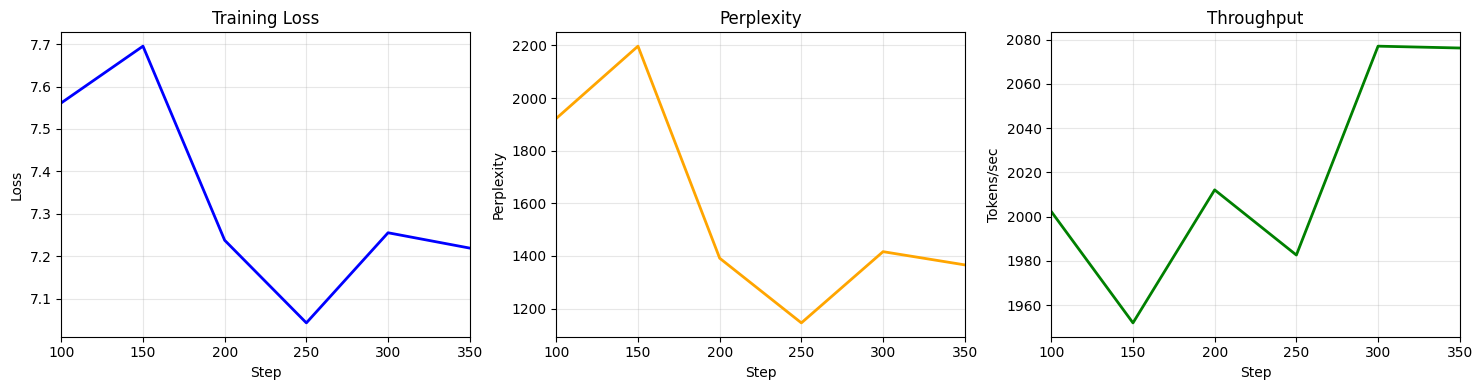

Training HOPE Pilot (chinchilla):   0%|          | 0/740001 [00:00<?, ?it/s]


GPU MEMORY: After First Training Step
🍎 MPS - First training step completed successfully


GPU MEMORY: During Training (Step 1)
🍎 MPS Allocated: 3.34 GB
🔧 Metal Driver:  15.43 GB
💾 Unified Memory: 24.20 GB / 32.00 GB
📊 Available: 5.97 GB (18.7%)
💡 For detailed GPU tracking: pip install asitop && sudo asitop

📊 Step 0: Updated plot with 1 data points
📊 Step 50: Updated plot with 2 data points
📊 Step 100: Updated plot with 3 data points
📊 Step 150: Updated plot with 4 data points
📊 Step 200: Updated plot with 5 data points
📊 Step 250: Updated plot with 6 data points
📊 Step 300: Updated plot with 7 data points
📊 Step 350: Updated plot with 8 data points


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import gc

def train():
    model.train()
    
    # Load existing metrics history if resuming
    metrics_history = ckpt_manager.load_metrics()
    
    # Determine starting step from metrics history
    if metrics_history:
        resume_step = metrics_history[-1]['step']
        print(f"📊 Found existing metrics - resuming from step {resume_step}")
    else:
        resume_step = start_step
        print(f"📊 No existing metrics - starting from step {resume_step}")
    
    # Track initial training memory
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        print_gpu_memory("Before Training Starts")
    elif device.type == 'mps':
        torch.mps.empty_cache()
        print_gpu_memory("Before Training Starts")
    
    # Setup live plotting
    plt.ioff()  # Disable default interactive mode, we'll handle updates manually
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Initialize empty plots
    loss_line, = axes[0].plot([], [], 'b-', linewidth=2)
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].grid(True, alpha=0.3)
    
    ppl_line, = axes[1].plot([], [], 'orange', linewidth=2)
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Perplexity')
    axes[1].set_title('Perplexity')
    axes[1].grid(True, alpha=0.3)
    
    throughput_line, = axes[2].plot([], [], 'g-', linewidth=2)
    axes[2].set_xlabel('Step')
    axes[2].set_ylabel('Tokens/sec')
    axes[2].set_title('Throughput')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Display the figure initially
    display_handle = display(fig, display_id=True)
    
    # If resuming and plot exists, update it immediately
    if metrics_history and ckpt_manager.plot_exists():
        print(f"📊 Restoring plot from checkpoint ({len(metrics_history)} data points)")
    
    def sample_metrics_for_plotting(filtered_metrics, max_points=5000):
        """
        Uniform sampling that maintains even distribution across training.
        Preserves overall trends and key points while limiting memory usage.
        """
        if len(filtered_metrics) <= max_points:
            return filtered_metrics
        
        n = len(filtered_metrics)
        
        # Calculate sampling step to get approximately max_points
        step = n / max_points
        
        # Use uniform sampling for even distribution
        indices = [int(i * step) for i in range(max_points)]
        
        # Always include last point
        if indices[-1] != n - 1:
            indices[-1] = n - 1
        
        sampled = [filtered_metrics[i] for i in indices]
        
        return sampled
    
    def update_plot():
        """Update the live plot with current metrics"""
        if not metrics_history:
            return
        
        # Filter to only show steps >= 100 to reduce noise from early training
        filtered_metrics = [m for m in metrics_history if m['step'] >= 100]
        
        if not filtered_metrics:
            return  # Nothing to plot yet
        
        # Smart sampling for memory efficiency (preserves trends)
        MAX_PLOT_POINTS = 5000
        original_count = len(filtered_metrics)
        filtered_metrics = sample_metrics_for_plotting(filtered_metrics, MAX_PLOT_POINTS)
        
        # Optional: Log when sampling occurs (only once)
        if len(filtered_metrics) < original_count:
            if not hasattr(update_plot, '_sampling_logged'):
                print(f"📊 Plot sampling activated: showing {len(filtered_metrics)}/{original_count} points (trends preserved)")
                update_plot._sampling_logged = True
        
        steps = [m['step'] for m in filtered_metrics]
        losses = [m['loss'] for m in filtered_metrics]
        ppls = [m['ppl'] for m in filtered_metrics]
        tok_per_sec = [m['tokens_per_sec'] for m in filtered_metrics]
        
        # Update loss plot
        loss_line.set_data(steps, losses)
        axes[0].relim()
        axes[0].autoscale_view()
        if len(steps) > 0:
            axes[0].set_xlim(left=100, right=max(steps[-1], 150))  # Dynamic right limit
        
        # Update perplexity plot
        ppl_line.set_data(steps, ppls)
        axes[1].relim()
        axes[1].autoscale_view()
        if len(steps) > 0:
            axes[1].set_xlim(left=100, right=max(steps[-1], 150))  # Dynamic right limit
        
        # Update throughput plot
        throughput_line.set_data(steps, tok_per_sec)
        axes[2].relim()
        axes[2].autoscale_view()
        if len(steps) > 0:
            axes[2].set_xlim(left=100, right=max(steps[-1], 150))  # Dynamic right limit
        
        # Update the display
        display_handle.update(fig)
        
        # CRITICAL: Force garbage collection to prevent memory leak
        del steps, losses, ppls, tok_per_sec, filtered_metrics
        gc.collect()
    
    # Update plot immediately if resuming
    if metrics_history:
        update_plot()
    
    step_iter = iter(dataloader)
    pbar = tqdm(range(resume_step, config.total_steps), 
                desc=f"Training HOPE Pilot ({DATA_PRESET})", 
                initial=resume_step, 
                total=config.total_steps)
    
    start_time = time.time()
    step_times = []
    
    for step in pbar:
        step_start = time.time()
        
        # Get batch
        try:
            batch_x, batch_y = next(step_iter)
        except StopIteration:
            step_iter = iter(dataloader)
            batch_x, batch_y = next(step_iter)
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass with mixed precision
        autocast_enabled = config.use_amp and device.type in ['cuda', 'mps']
        if device.type == 'cuda':
            with torch.cuda.amp.autocast(enabled=autocast_enabled):
                logits = model(batch_x)
                loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), batch_y.reshape(-1))
        else:
            # MPS or CPU
            logits = model(batch_x)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), batch_y.reshape(-1))
        
        # Backward pass
        for opt in optimizers.values():
            opt.zero_grad()
        
        if scaler is not None:
            # CUDA with GradScaler
            scaler.scale(loss).backward()
            for opt in optimizers.values():
                scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            for opt in optimizers.values():
                scaler.step(opt)
            scaler.update()
        else:
            # MPS or CUDA without scaler
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            for opt in optimizers.values():
                opt.step()
        
        # Metrics
        step_time = time.time() - step_start
        step_times.append(step_time)
        if len(step_times) > 100:
            step_times.pop(0)
        
        # ONE-TIME: Print memory after first training step
        if step == resume_step:
            if device.type == 'cuda':
                peak_allocated = torch.cuda.max_memory_allocated() / (1024**3)
                peak_reserved = torch.cuda.max_memory_reserved() / (1024**3)
                print(f"\n{'='*80}")
                print(f"GPU MEMORY: After First Training Step")
                print(f"{'='*80}")
                print(f"🔥 Peak Allocated: {peak_allocated:.2f} GB")
                print(f"🔥 Peak Reserved:  {peak_reserved:.2f} GB")
                print(f"{'='*80}\n")
                print_gpu_memory("During Training (Step 1)")
            elif device.type == 'mps':
                print(f"\n{'='*80}")
                print(f"GPU MEMORY: After First Training Step")
                print(f"{'='*80}")
                print(f"🍎 MPS - First training step completed successfully")
                print(f"{'='*80}\n")
                print_gpu_memory("During Training (Step 1)")
        
        avg_step_time = sum(step_times) / len(step_times)
        eta_seconds = avg_step_time * (config.total_steps - step - 1)
        eta_hours = eta_seconds / 3600
        eta_days = eta_hours / 24
        tokens_per_sec = (config.batch_size * config.seq_len) / step_time
        
        ppl = torch.exp(loss.detach()).item()
        
        # Format ETA
        if eta_days >= 1:
            eta_str = f'{eta_days:.1f}d'
        elif eta_hours >= 1:
            eta_str = f'{eta_hours:.1f}h'
        else:
            eta_str = f'{eta_seconds/60:.0f}m'
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'ppl': f'{ppl:.2f}',
            'tok/s': f'{tokens_per_sec:.0f}',
            'ETA': eta_str
        })
        
        # Log metrics
        if step % 50 == 0:  # Log every 50 steps
            metrics = {
                'step': step,
                'loss': loss.item(),
                'ppl': ppl,
                'step_time': step_time,
                'tokens_per_sec': tokens_per_sec
            }
            metrics_history.append(metrics)
            
            # Update plot every 50 steps
            update_plot()
            print(f"📊 Step {step}: Updated plot with {len(metrics_history)} data points")
        
        # Save checkpoint
        if (step + 1) % config.save_interval == 0 or (step + 1) == config.total_steps:
            metrics_to_save = {
                'loss': loss.item(),
                'ppl': ppl,
                'step_time': avg_step_time,
                'tokens_per_sec': tokens_per_sec
            }
            ckpt_manager.save_checkpoint(model, optimizers, step + 1, metrics_to_save, scaler)
            
            # Save metrics history to file
            ckpt_manager.save_metrics(metrics_history)
            
            # Update plot at checkpoint
            update_plot()
            
            # Save the plot at checkpoint
            ckpt_manager.save_plot(fig)
    
    pbar.close()
    
    total_time = time.time() - start_time
    print(f"\n{'='*80}")
    print("TRAINING COMPLETE")
    print("="*80)
    print(f"Total time: {total_time/3600:.2f} hours ({total_time/86400:.2f} days)")
    print(f"Final loss: {loss.item():.4f}")
    print(f"Final perplexity: {ppl:.2f}")
    if metrics_history:
        print(f"Average tokens/sec: {sum(m['tokens_per_sec'] for m in metrics_history)/len(metrics_history):.0f}")
    print(f"Total tokens trained: {config.total_steps * config.batch_size * config.seq_len / 1e9:.2f}B")
    
    # Final memory stats
    if device.type == 'cuda':
        peak_allocated = torch.cuda.max_memory_allocated() / (1024**3)
        peak_reserved = torch.cuda.max_memory_reserved() / (1024**3)
        print(f"\n🔥 Peak GPU Memory During Training:")
        print(f"   Allocated: {peak_allocated:.2f} GB")
        print(f"   Reserved:  {peak_reserved:.2f} GB")
        print_gpu_memory("After Training Complete")
    elif device.type == 'mps':
        print(f"\n🍎 MPS Training Complete")
        print_gpu_memory("After Training Complete")
    
    # Save final metrics and plot
    ckpt_manager.save_metrics(metrics_history)
    ckpt_manager.save_plot(fig)
    print(f"✓ Saved metrics history to: {ckpt_manager.metrics_file}")
    print(f"✓ Saved final plot to: {ckpt_manager.plot_file}")
    
    # Final cleanup to free memory
    plt.close(fig)
    gc.collect()
    
    return metrics_history

# Run training
print("\n" + "="*80)
print(f"STARTING TRAINING - {DATA_PRESET.upper()} DATASET")
print("="*80)
print(f"Steps: {start_step:,} → {config.total_steps:,}")
print(f"Batch size: {config.batch_size}")
print(f"Sequence length: {config.seq_len}")
print(f"Total tokens per step: {config.batch_size * config.seq_len:,}")
print(f"Total training tokens: {config.total_steps * config.batch_size * config.seq_len / 1e9:.2f}B")
estimated_hours = (config.total_steps * 7) / 3600
print(f"Estimated time: ~{estimated_hours:.1f} hours (~{estimated_hours/24:.1f} days)\n")

metrics_history = train()

## 13. Visualize Training Metrics

Plot loss, perplexity, and throughput over training.

In [ ]:
import matplotlib.pyplot as plt

if metrics_history:
    # Filter to only show steps >= 100 to reduce noise from early training
    filtered_metrics = [m for m in metrics_history if m['step'] >= 100]
    
    if filtered_metrics:
        steps = [m['step'] for m in filtered_metrics]
        losses = [m['loss'] for m in filtered_metrics]
        ppls = [m['ppl'] for m in filtered_metrics]
        tok_per_sec = [m['tokens_per_sec'] for m in filtered_metrics]
    else:
        steps, losses, ppls, tok_per_sec = [], [], [], []
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(steps, losses, linewidth=2)
    axes[0].set_xlabel('Step', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Perplexity
    axes[1].plot(steps, ppls, linewidth=2, color='orange')
    axes[1].set_xlabel('Step', fontsize=12)
    axes[1].set_ylabel('Perplexity', fontsize=12)
    axes[1].set_title('Training Perplexity', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Throughput
    axes[2].plot(steps, tok_per_sec, linewidth=2, color='green')
    axes[2].set_xlabel('Step', fontsize=12)
    axes[2].set_ylabel('Tokens/sec', fontsize=12)
    axes[2].set_title('Throughput', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{CHECKPOINT_DIR}/training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved training plot to {CHECKPOINT_DIR}/training_metrics.png")
else:
    print("No metrics to plot")

## 14. Interactive Chat Interface

Test your trained model with interactive Q&A!

**Commands:**
- `/temp X` - Set temperature (0.1-2.0)
- `/tokens X` - Set max tokens (1-200)
- `/show on/off` - Show/hide token predictions with actual words
- `/quit` - Exit chat

Just type your prompt and press Enter to generate text.

In [ ]:
class InteractiveChat:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.sp = tokenizer
        self.device = device
        self.model.eval()
    
    def encode(self, text: str) -> torch.Tensor:
        token_ids = self.sp.EncodeAsIds(text)
        return torch.tensor([token_ids], dtype=torch.long, device=self.device)
    
    def decode(self, token_ids: torch.Tensor) -> str:
        if token_ids.dim() == 2:
            token_ids = token_ids[0]
        return self.sp.DecodeIds(token_ids.tolist())
    
    def decode_token(self, token_id: int) -> str:
        return self.sp.IdToPiece(token_id)
    
    def generate(self, prompt: str, max_tokens: int = 50, 
                 temperature: float = 0.8, show_predictions: bool = False):
        tokens = self.encode(prompt)
        generated_tokens = tokens[0].tolist()
        
        print(f"\n{'='*80}")
        print(f"📝 Prompt: {prompt}")
        print(f"🎲 Temperature: {temperature} | Max tokens: {max_tokens}")
        print("="*80)
        
        with torch.no_grad():
            for i in range(max_tokens):
                input_tokens = torch.tensor([generated_tokens], device=self.device)
                
                # Truncate if too long
                if input_tokens.size(1) > config.seq_len:
                    input_tokens = input_tokens[:, -config.seq_len:]
                
                logits = self.model(input_tokens)
                next_token_logits = logits[0, -1, :] / temperature
                probs = F.softmax(next_token_logits, dim=-1)
                
                # Sample next token
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                # Show predictions with actual words
                if show_predictions and i < 5:
                    top_probs, top_indices = torch.topk(probs, k=3)
                    print(f"\n🔮 Prediction {i+1}:")
                    for prob, idx in zip(top_probs, top_indices):
                        token_text = self.decode_token(idx.item())
                        print(f"  {prob.item()*100:5.1f}% → '{token_text}'")
                    selected_text = self.decode_token(next_token)
                    print(f"  ✅ Selected: '{selected_text}'")
                
                generated_tokens.append(next_token)
                
                # Check for EOS
                if next_token == self.sp.eos_id():
                    break
        
        full_text = self.decode(torch.tensor(generated_tokens))
        return full_text
    
    def chat_loop(self):
        print("\n" + "="*80)
        print("🤖 HOPE PILOT INTERACTIVE CHAT")
        print("="*80)
        print("Commands:")
        print("  /temp X    - Set temperature (0.1-2.0)")
        print("  /tokens X  - Set max tokens (1-200)")
        print("  /show on   - Show token predictions")
        print("  /show off  - Hide token predictions")
        print("  /quit      - Exit\n")
        
        temperature = 0.8
        max_tokens = 50
        show_predictions = False
        
        while True:
            try:
                prompt = input("\n💬 You: ").strip()
                
                if not prompt:
                    continue
                
                # Handle commands
                if prompt == '/quit':
                    print("👋 Goodbye!")
                    break
                elif prompt.startswith('/temp '):
                    try:
                        temperature = float(prompt.split()[1])
                        temperature = max(0.1, min(2.0, temperature))
                        print(f"✓ Temperature set to {temperature}")
                    except:
                        print("❌ Invalid. Use: /temp 0.8")
                    continue
                elif prompt.startswith('/tokens '):
                    try:
                        max_tokens = int(prompt.split()[1])
                        max_tokens = max(1, min(200, max_tokens))
                        print(f"✓ Max tokens set to {max_tokens}")
                    except:
                        print("❌ Invalid. Use: /tokens 50")
                    continue
                elif prompt == '/show on':
                    show_predictions = True
                    print("✓ Showing predictions")
                    continue
                elif prompt == '/show off':
                    show_predictions = False
                    print("✓ Hiding predictions")
                    continue
                elif prompt.startswith('/'):
                    print("❌ Unknown command")
                    continue
                
                # Generate response
                response = self.generate(
                    prompt, 
                    max_tokens=max_tokens,
                    temperature=temperature,
                    show_predictions=show_predictions
                )
                
                print(f"\n🤖 Model: {response}\n")
                print("─" * 80)
                
            except KeyboardInterrupt:
                print("\n👋 Goodbye!")
                break
            except Exception as e:
                print(f"❌ Error: {e}")

print("✓ Chat interface ready")

In [ ]:
# Initialize chat interface
chat = InteractiveChat(model, sp, device)

# Quick test generation
print("\n📋 Quick Test:")
test_prompt = "The future of artificial intelligence is"
result = chat.generate(test_prompt, max_tokens=30, temperature=0.8, show_predictions=True)

print(f"\n✓ Model is ready for interactive chat!")
print(f"\nTo start chatting, run: chat.chat_loop()")

In [ ]:
# Run interactive chat loop
# Uncomment to start chatting:
# chat.chat_loop()